# Image classification

Back in 2017 when I first tried fast.ai, the "hello world" of image classification was how to classify cats versus dogs. That task is now too easy for modern approaches, and won't allow us to explore the nuances in model training.

The task in this notebook consists of classifying 13 pet breeds from images, which is a substantially more difficult problem.

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [3]:
Path.BASE_PATH = path # display paths relative to BASE_PATH

In [4]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [5]:
(path/"images").ls()

(#7393) [Path('images/Sphynx_185.jpg'),Path('images/japanese_chin_111.jpg'),Path('images/Ragdoll_166.jpg'),Path('images/boxer_96.jpg'),Path('images/Maine_Coon_27.jpg'),Path('images/japanese_chin_3.jpg'),Path('images/american_pit_bull_terrier_190.jpg'),Path('images/pomeranian_94.jpg'),Path('images/wheaten_terrier_27.jpg'),Path('images/great_pyrenees_100.jpg')...]

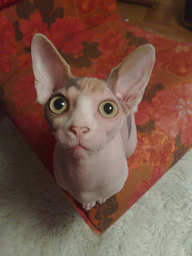

In [12]:
im = Image.open(path/'images'/'Sphynx_185.jpg')
im.to_thumb(256)

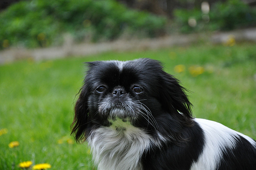

In [13]:
im = Image.open(path/'images'/'japanese_chin_111.jpg')
im.to_thumb(256)

So `./images` contains 7393 images of pets, where the breed is in the file name. If the first letter is upper-case, it's a cat. If the first letter is lower-case, it's a dog.

In [6]:
(path/"annotations").ls()

(#7) [Path('annotations/test.txt'),Path('annotations/._trimaps'),Path('annotations/README'),Path('annotations/list.txt'),Path('annotations/trainval.txt'),Path('annotations/xmls'),Path('annotations/trimaps')]

## Build a datablock

In [83]:
get_pet_label = lambda s: re.findall(r'(.+)_\d+\.jpg$', s.name)[0]

In [84]:
get_pet_label((path/'images').ls()[1])

'japanese_chin'

In [95]:
doc(aug_transforms)

aug_transforms [source] aug_transforms ( mult = 1.0 , do_flip = True , flip_vert = False , max_rotate = 10.0 , min_zoom = 1.0 , max_zoom = 1.1 , max_lighting = 0.2 , max_warp = 0.2 , p_affine = 0.75 , p_lighting = 0.75 , xtra_tfms = None , size = None , mode = 'bilinear' , pad_mode = 'reflection' , align_corners = True , batch = False , min_scale = 1.0 ) 
 
 Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms. 
 Show in docs

In [93]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # the independent and dependent variable types
    get_items=get_image_files, # how to get a list of image files -- in this case from folders in the path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # how to partition the data into training/validation sets
    get_y=get_pet_label, # how to get the target -- in this case from a regular expression
    # alternatively:
    #get_y=using_attr(RegexLabeller(r'(.+)_\d+\.jpg$'), 'name'),
    item_tfms=Resize(460), # transformations to apply to the data before handing to the GPU
    batch_tfms=aug_transforms(size=224, min_scale=0.75) # transformations to apply to the data after handing to the GPU. Data augmentation.
)

### Aside: Presizing

`item_tfms=Resize(460)` resizes the image to quite a large random square image (460x460). `batch_tfms=...` uses `RandomResizeCrop` in the `size=224` argument to output an augmented square image which is 224x224.

The first step is used so that the image augmentation can take place on the GPU.

Fastai's implementation of image augmentation is also performed in a less lossy way, by applying the desired transformations only once, and then interpolated only once. Most other deep learning libraries perform interpolation at each step of the augmentation, which damages image quality.

In [91]:
dls = pets.dataloaders(path/'images')

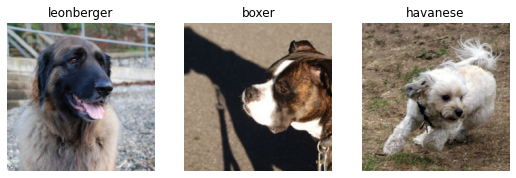

In [96]:
dls.valid.show_batch(nrows=1, ncols=3)

To inspect the image augmentation:

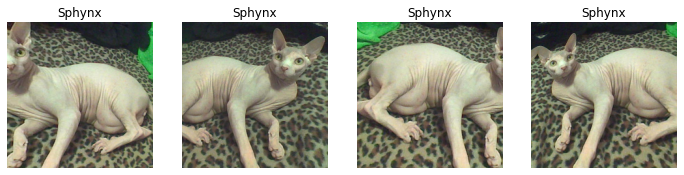

In [100]:
dls.show_batch(nrows=1, ncols=4, unique=True)

In [107]:
# # This line will print out progress in building the DataBlock. Useful for debugging.
# pets.summary(path/'images')

Tip: Instead of spending loads of time data cleaning, build a model as soon as you have a `dataloaders`. A model will help understand where the data are dirty.

In [108]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.511679,0.350663,0.113667,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.491207,0.359852,0.108931,00:43
1,0.325416,0.247666,0.085927,00:43


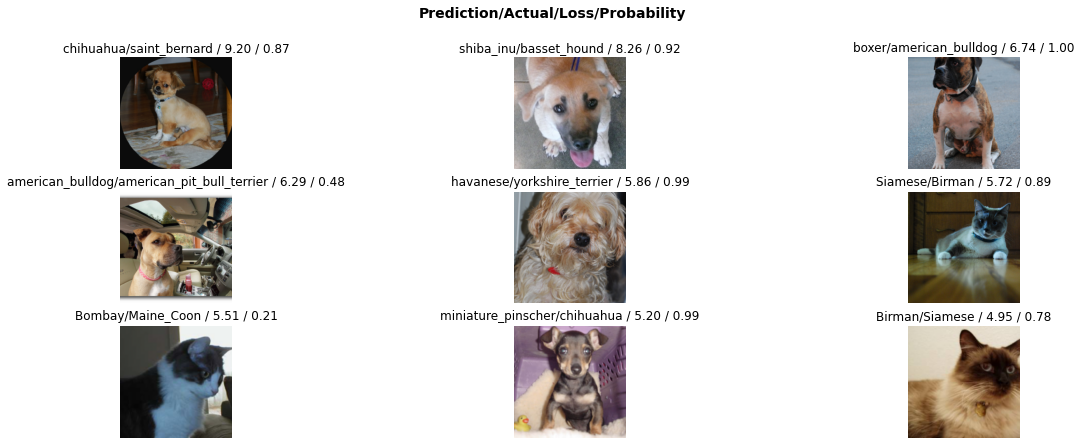

In [116]:
interp.plot_top_losses(9, nrows=3, ncols=3, figsize=(20,7))

The loss function fastai decided to use was:

In [117]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

## Cross entropy loss

In [137]:
x,y = dls.one_batch()

In [138]:
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [139]:
y

TensorCategory([ 8, 23, 15, 35, 12, 22,  6,  3,  3, 15, 33, 26,  1, 29, 10, 34, 15, 15,
        31,  0, 34,  8, 14, 22, 23, 24,  0, 12, 36,  1, 26, 23,  4, 20,  2, 19,
        29, 30, 35, 26,  2, 11, 11, 21, 23, 12, 28,  6,  0, 27, 16, 24, 16, 24,
        25,  7, 12, 15,  2, 19, 32, 31, 22, 26], device='cuda:0')

Where the target represents an element of the vocab:

In [140]:
dls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

In [141]:
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([2.3954e-03, 2.3436e-04, 3.0552e-03, 1.4047e-04, 1.6651e-03, 5.2646e-05,
        1.9494e-03, 3.4655e-02, 9.5359e-01, 1.4632e-05, 2.9593e-05, 7.3133e-05,
        2.0250e-05, 1.9265e-04, 9.4075e-05, 1.2137e-05, 2.9148e-05, 1.4567e-04,
        1.2304e-05, 2.6075e-05, 3.3693e-06, 8.1608e-05, 1.3084e-04, 8.4120e-05,
        7.2864e-06, 2.4045e-04, 5.7778e-05, 8.2649e-05, 4.0332e-04, 1.8318e-05,
        1.7229e-05, 1.1795e-04, 2.1380e-04, 4.9166e-06, 7.1514e-06, 5.3080e-05,
        8.8253e-05])

In [142]:
dls.vocab[preds[0].argmax()]

'Ragdoll'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


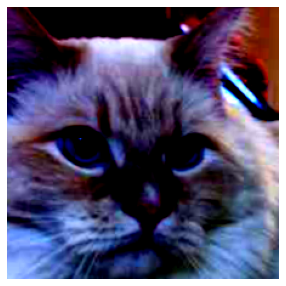

In [144]:
show_image(x[0]);